<a href="https://colab.research.google.com/github/kwagdm/TIL/blob/master/%EB%85%BC%EB%AC%B8%EA%B5%AC%ED%98%84_contextualized.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd

ratings_train = pd.read_excel('ratings_train.xlsx')
ratings_test = pd.read_excel('ratings_test.xlsx')

In [2]:
ratings_train = ratings_train.dropna()
ratings_test = ratings_test.dropna()

In [3]:
ratings_train.head()

,id,document,label
0,9976970,아 더빙.. 진짜 짜증나네요 목소리,0
1,3819312,흠...포스터보고 초딩영화줄....오버연기조차 가볍지 않구나,1
2,10265843,너무재밓었다그래서보는것을추천한다,0
3,9045019,교도소 이야기구먼 ..솔직히 재미는 없다..평점 조정,0
4,6483659,사이몬페그의 익살스런 연기가 돋보였던 영화!스파이더맨에서 늙어보이기만 했던 커스틴 ...,1


In [4]:
document_list = []                                    #document만 리스트에 넣어두자
for sen in ratings_train['document']:
  document_list.append(sen)

In [5]:
for i in range(len(document_list)):
  if type(document_list[i]) != str:                   #string이 아닌 것들은 제외
    document_list[i] = str(document_list[i])

#1. 전처리 없이 진행

In [117]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

vocab_size = 10000
tokenizer = Tokenizer(num_words =vocab_size, oov_token="<OOV>")
tokenizer.fit_on_texts(document_list)
word_index_training = tokenizer.word_index

sequences_training = tokenizer.texts_to_sequences(document_list)

padded_training = pad_sequences(sequences_training, maxlen=59, truncating = 'post')      

# training 데이터를 토큰화 한 후 벡터화하자



In [7]:
document_test_list = []
for sen in ratings_test['document']:            
  document_test_list.append(sen)

In [8]:
for i in range(len(document_test_list)):
  if type(document_test_list[i]) != str:
    document_test_list[i] = str(document_test_list[i])


In [112]:
sequences_test = tokenizer.texts_to_sequences(document_test_list)

padded_test = pad_sequences(sequences_test, maxlen=59, truncating = 'post')     #테스트 데이터도 토큰화 후 벡터화   

In [10]:
training_label = []
for lab in ratings_train['label']:
  training_label.append(lab)
test_label = []
for lab in ratings_test['label']:
  test_label.append(lab)                                                        #각각의 라벨들도 리스트에 넣자

In [11]:
import numpy as np
training_label_final = np.array(training_label)                                 #라벨을 array로 만들자
test_label_final = np.array(test_label)

In [118]:
import tensorflow as tf
from tensorflow import keras

vocab_size = 10000
embedding_dim = 50
max_length = 59
oov_tok = '<OOV>'

sequence_input = tf.keras.Input(shape=(max_length,), dtype='int32')
embedding_layer = tf.keras.layers.Embedding(vocab_size,
                            embedding_dim,
                            input_length=max_length,
                            trainable=False)
embedded_sequences = embedding_layer(sequence_input)
convs = []
filter_sizes = [3,4,5]
for fsz in filter_sizes:
    x = tf.keras.layers.Conv1D(128, fsz, activation='relu',padding='same')(embedded_sequences)
    x = tf.keras.layers.MaxPooling1D()(x)
    convs.append(x)

kernel_regularizer=tf.keras.regularizers.l2(0.02)
x = tf.keras.layers.Concatenate(axis=-1)(convs)
x = tf.keras.layers.Flatten()(x)
x = tf.keras.layers.Dense(128, activation='relu')(x)
x = tf.keras.layers.Dropout(0.5)(x)
output = tf.keras.layers.Dense(1, activation='sigmoid')(x)
model = tf.keras.Model(sequence_input, output)
callback = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=3)
model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])



In [119]:
num_epochs = 10
history1 = model.fit(padded_training, training_label_final, epochs = num_epochs, validation_data = (padded_test, test_label_final), callbacks=[callback])

Epoch 1/10
4687/4687 [==============================] - 39s 8ms/step - loss: 0.6124 - accuracy: 0.6439 - val_loss: 0.5527 - val_accuracy: 0.7005
Epoch 2/10
4687/4687 [==============================] - 39s 8ms/step - loss: 0.5178 - accuracy: 0.7261 - val_loss: 0.5333 - val_accuracy: 0.7141
Epoch 3/10
4687/4687 [==============================] - 39s 8ms/step - loss: 0.4690 - accuracy: 0.7584 - val_loss: 0.5138 - val_accuracy: 0.7323
Epoch 4/10
4687/4687 [==============================] - 39s 8ms/step - loss: 0.4283 - accuracy: 0.7834 - val_loss: 0.5348 - val_accuracy: 0.7297
Epoch 5/10
4687/4687 [==============================] - 38s 8ms/step - loss: 0.3962 - accuracy: 0.8009 - val_loss: 0.5653 - val_accuracy: 0.7242
Epoch 6/10
4687/4687 [==============================] - 39s 8ms/step - loss: 0.3702 - accuracy: 0.8135 - val_loss: 0.5924 - val_accuracy: 0.7206


In [124]:
sentence = ["와우 정말 재밌었습니다. 배우들의 연기 역시 멋있었어요. 평점 높게 드립니다.", "실망스럽다. 한심한 영화다. 이것도 영화라고 참."]
sequence_exp = tokenizer.texts_to_sequences(sentence)
padded_exp = pad_sequences(sequence_exp, maxlen = max_length, padding = 'post', truncating= 'post')
print(model.predict(padded_exp).round(2))

[[0.16]
 [0.59]]


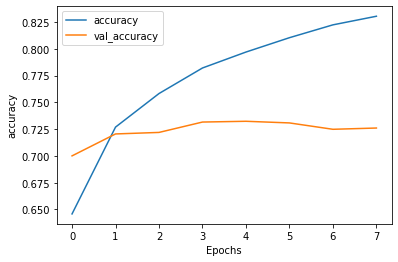

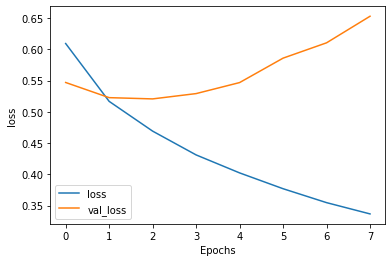

In [40]:
import matplotlib.pyplot as plt

def plot_graphs(history, string):
  plt.plot(history.history[string])
  plt.plot(history.history['val_' + string])
  plt.xlabel("Epochs")
  plt.ylabel(string)
  plt.legend([string, 'val_' + string])
  plt.show()

plot_graphs(history1, 'accuracy')
plot_graphs(history1, 'loss')         #epochs가 많아질때 overfitting될 가능성을 보여줌

#2. 전처리 후 진행_pos tagging만 한 후 진행

In [15]:
!sudo apt-get install g++ openjdk-7-jdk # Install Java 1.7+
!sudo apt-get install python-dev; pip install konlpy     # Python 2.x
!sudo apt-get install python3-dev; pip3 install konlpy   # Python 3.x
!sudo apt-get install curl
!bash <(curl -s https://raw.githubusercontent.com/konlpy/konlpy/master/scripts/mecab.sh)

from konlpy.tag import Mecab
mecab = Mecab()


Reading package lists... Done
Building dependency tree       
Reading state information... Done
Package openjdk-7-jdk is not available, but is referred to by another package.
This may mean that the package is missing, has been obsoleted, or
is only available from another source

E: Package 'openjdk-7-jdk' has no installation candidate
Reading package lists... Done
Building dependency tree       
Reading state information... Done
python-dev is already the newest version (2.7.15~rc1-1).
The following package was automatically installed and is no longer required:
  libnvidia-common-440
Use 'sudo apt autoremove' to remove it.
0 upgraded, 0 newly installed, 0 to remove and 35 not upgraded.
     |████████████████████████████████| 19.4MB 50.6MB/s 
     |████████████████████████████████| 3.8MB 40.0MB/s 
     |████████████████████████████████| 92kB 9.3MB/s 
  Found existing installation: beautifulsoup4 4.6.3
    Uninstalling beautifulsoup4-4.6.3:
      Successfully uninstalled beautifulsoup4-4.

In [17]:
# Mecab으로 전처리
preprocessed_docs = []
for doc in document_list:
  pos = mecab.pos(doc)
  preprocessed_docs.append(pos)

In [18]:
words = []
for sen in preprocessed_docs:
  word = []
  for tokens in sen:
    word.append(tokens[0])
  words.append(word)

In [19]:
pos_sentence_train = []
for word in words:
  pos_sentence_train.append(' '.join(word))

In [21]:
test_preprocessed_docs = []
for doc in document_test_list:
  pos = mecab.pos(doc)
  test_preprocessed_docs.append(pos)

In [22]:
test_words = []
for sen in test_preprocessed_docs:
  test_word = []
  for tokens in sen:
    test_word.append(tokens[0])
  test_words.append(test_word)

In [23]:
pos_sentence_test = []
for word in test_words:
  pos_sentence_test.append(' '.join(word))

In [128]:
tokenizer.fit_on_texts(pos_sentence_train)
pos_sequences_train = tokenizer.texts_to_sequences(pos_sentence_train)
pos_padded_train = pad_sequences(pos_sequences_train, maxlen=59, truncating = 'post')    

import pickle
with open('tokenizer_contextualized.pickle', 'wb') as handle:
    pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [25]:
pos_sequences_test = tokenizer.texts_to_sequences(pos_sentence_test)
pos_padded_test = pad_sequences(pos_sequences_test, maxlen=59, truncating = 'post')

In [129]:
import json
from collections import OrderedDict
file_data = OrderedDict()

file_data['max_len'] = 59
file_data['pad_type'] = 'pre'
file_data['trunc_type'] = 'post'

with open('parameter_contextualized.json', 'w', encoding = 'utf-8') as make_file:
  json.dump(file_data, make_file, ensure_ascii=False, indent='\t')


In [42]:
import tensorflow as tf
from tensorflow import keras

vocab_size = 10000
embedding_dim = 50
max_length = 59
oov_tok = '<OOV>'

sequence_input = tf.keras.Input(shape=(max_length,), dtype='int32')
embedding_layer = tf.keras.layers.Embedding(vocab_size,
                            embedding_dim,
                            input_length=max_length,
                            trainable=False)
embedded_sequences = embedding_layer(sequence_input)
convs = []
filter_sizes = [3,4,5]
for fsz in filter_sizes:
    x = tf.keras.layers.Conv1D(128, fsz, activation='relu',padding='same')(embedded_sequences)
    x = tf.keras.layers.MaxPooling1D()(x)
    convs.append(x)

kernel_regularizer=tf.keras.regularizers.l2(0.02)
x = tf.keras.layers.Concatenate(axis=-1)(convs)
x = tf.keras.layers.Flatten()(x)
x = tf.keras.layers.Dense(128, activation='relu')(x)
x = tf.keras.layers.Dropout(0.5)(x)
output = tf.keras.layers.Dense(1, activation='sigmoid')(x)
model2 = tf.keras.Model(sequence_input, output)
callback = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=3)
model2.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

num_epochs = 10
history2 = model2.fit(pos_padded_train, training_label_final, epochs = num_epochs, validation_data = (pos_padded_test, test_label_final), callbacks=[callback])

Epoch 1/10
4687/4687 [==============================] - 39s 8ms/step - loss: 0.4886 - accuracy: 0.7534 - val_loss: 0.4167 - val_accuracy: 0.8019
Epoch 2/10
4687/4687 [==============================] - 40s 8ms/step - loss: 0.3771 - accuracy: 0.8312 - val_loss: 0.4060 - val_accuracy: 0.8114
Epoch 3/10
4687/4687 [==============================] - 38s 8ms/step - loss: 0.3262 - accuracy: 0.8578 - val_loss: 0.3932 - val_accuracy: 0.8230
Epoch 4/10
4687/4687 [==============================] - 39s 8ms/step - loss: 0.2866 - accuracy: 0.8775 - val_loss: 0.4158 - val_accuracy: 0.8176
Epoch 5/10
4687/4687 [==============================] - 39s 8ms/step - loss: 0.2534 - accuracy: 0.8933 - val_loss: 0.4645 - val_accuracy: 0.8132
Epoch 6/10
4687/4687 [==============================] - 39s 8ms/step - loss: 0.2256 - accuracy: 0.9058 - val_loss: 0.4786 - val_accuracy: 0.8157


In [133]:
!mkdir -p saved_model
model2.save('model_contextualized')

INFO:tensorflow:Assets written to: model_contextualized/assets


In [125]:
sentence = ["와우 정말 재밌었습니다. 배우들의 연기 역시 멋있었어요. 평점 높게 드립니다.", "실망스럽다. 한심한 영화다. 이것도 영화라고 참."]
sequence_exp = tokenizer.texts_to_sequences(sentence)
padded_exp = pad_sequences(sequence_exp, maxlen = max_length, padding = 'post', truncating= 'post')
print(model2.predict(padded_exp).round(2))

[[0.5 ]
 [0.49]]


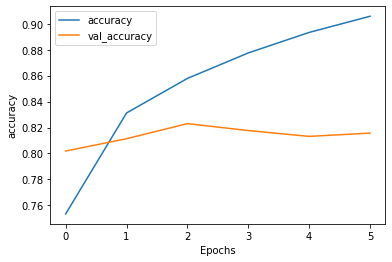

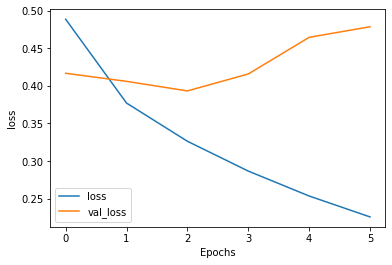

In [45]:
import matplotlib.pyplot as plt

def plot_graphs(history, string):
  plt.plot(history.history[string])
  plt.plot(history.history['val_' + string])
  plt.xlabel("Epochs")
  plt.ylabel(string)
  plt.legend([string, 'val_' + string])
  plt.show()

plot_graphs(history2, 'accuracy')
plot_graphs(history2, 'loss')         #epochs가 많아질때 overfitting될 가능성을 보여줌

#3. 전처리 후 진행_pos 중 불필요한 품사 삭제

In [46]:
unnecessary = ['SF', 'SP', 'SS', 'SE', 'SO', 'SW', 'NF', 'NV', 'NA', 'SL', 'SH', 'SN']
#부호, 분석불능, 한국어 이외 등

In [81]:
pos_only_train_words = []
for sen in preprocessed_docs:
  train_word = []  
  for tokens in sen:
    if tokens[1] not in unnecessary:
      train_word.append(tokens[0])
  pos_only_train_words.append(train_word)

In [84]:
pos_only_test_words = []
for sen in test_preprocessed_docs:
  test_word = []
  for tokens in sen:
    if tokens[1] not in unnecessary:
      test_word.append(tokens[0])
  pos_only_test_words.append(test_word)

In [85]:
pos_only_sentence_train = []
for word in pos_only_train_words:
  pos_only_sentence_train.append(' '.join(word))

In [86]:
pos_only_sentence_test= []
for word in pos_only_test_words:
  pos_only_sentence_test.append(' '.join(word))

In [87]:
len(preprocessed_docs), len(pos_only_train_words), len(pos_only_sentence_train), len(training_label_final), len(pos_only_padded_test)

(149974, 149974, 149974, 149974, 920731)

In [88]:
tokenizer.fit_on_texts(pos_only_sentence_train)
pos_only_sequences_train = tokenizer.texts_to_sequences(pos_only_sentence_train)
pos_only_padded_train = pad_sequences(pos_only_sequences_train, maxlen=59, truncating = 'post')     

In [89]:
pos_only_sequences_test = tokenizer.texts_to_sequences(pos_only_sentence_test)
pos_only_padded_test = pad_sequences(pos_only_sequences_test, maxlen=59, truncating = 'post')    

In [90]:
import tensorflow as tf
from tensorflow import keras

vocab_size = 10000
embedding_dim = 50
max_length = 59
oov_tok = '<OOV>'

sequence_input = tf.keras.Input(shape=(max_length,), dtype='int32')
embedding_layer = tf.keras.layers.Embedding(vocab_size,
                            embedding_dim,
                            input_length=max_length,
                            trainable=False)
embedded_sequences = embedding_layer(sequence_input)
convs = []
filter_sizes = [3,4,5]
for fsz in filter_sizes:
    x = tf.keras.layers.Conv1D(128, fsz, activation='relu',padding='same')(embedded_sequences)
    x = tf.keras.layers.MaxPooling1D()(x)
    convs.append(x)

kernel_regularizer=tf.keras.regularizers.l2(0.02)
x = tf.keras.layers.Concatenate(axis=-1)(convs)
x = tf.keras.layers.Flatten()(x)
x = tf.keras.layers.Dense(128, activation='relu')(x)
x = tf.keras.layers.Dropout(0.5)(x)
output = tf.keras.layers.Dense(1, activation='sigmoid')(x)
model3 = tf.keras.Model(sequence_input, output)
callback = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=3)
model3.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

num_epochs = 10
history3 = model3.fit(pos_only_padded_train, training_label_final, epochs = num_epochs, validation_data = (pos_only_padded_test, test_label_final), callbacks=[callback])

Epoch 1/10
4687/4687 [==============================] - 39s 8ms/step - loss: 0.4916 - accuracy: 0.7530 - val_loss: 0.4297 - val_accuracy: 0.7940
Epoch 2/10
4687/4687 [==============================] - 39s 8ms/step - loss: 0.3835 - accuracy: 0.8245 - val_loss: 0.4005 - val_accuracy: 0.8132
Epoch 3/10
4687/4687 [==============================] - 39s 8ms/step - loss: 0.3334 - accuracy: 0.8529 - val_loss: 0.4188 - val_accuracy: 0.8090
Epoch 4/10
4687/4687 [==============================] - 39s 8ms/step - loss: 0.2908 - accuracy: 0.8743 - val_loss: 0.4348 - val_accuracy: 0.8113
Epoch 5/10
4687/4687 [==============================] - 40s 9ms/step - loss: 0.2569 - accuracy: 0.8902 - val_loss: 0.6327 - val_accuracy: 0.7612


In [126]:
sentence = ["와우 정말 재밌었습니다. 배우들의 연기 역시 멋있었어요. 평점 높게 드립니다.", "실망스럽다. 한심한 영화다. 이것도 영화라고 참."]
sequence_exp = tokenizer.texts_to_sequences(sentence)
padded_exp = pad_sequences(sequence_exp, maxlen = max_length, padding = 'post', truncating= 'post')
print(model3.predict(padded_exp).round(2))

[[0.9 ]
 [0.62]]


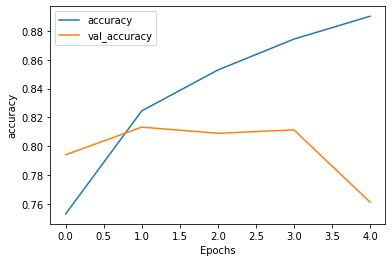

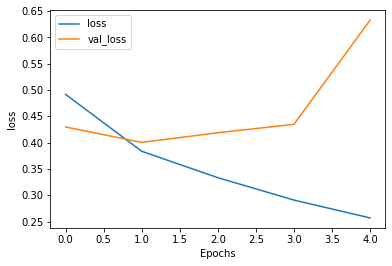

In [91]:
import matplotlib.pyplot as plt

def plot_graphs(history, string):
  plt.plot(history.history[string])
  plt.plot(history.history['val_' + string])
  plt.xlabel("Epochs")
  plt.ylabel(string)
  plt.legend([string, 'val_' + string])
  plt.show()

plot_graphs(history3, 'accuracy')
plot_graphs(history3, 'loss')         #epochs가 많아질때 overfitting될 가능성을 보여줌

#4. mecab으로 토큰화 한 것을 필터 사이즈 [1,2,3]으로 진행

In [99]:
import tensorflow as tf
from tensorflow import keras

vocab_size = 10000
embedding_dim = 50
max_length = 59
oov_tok = '<OOV>'

sequence_input = tf.keras.Input(shape=(max_length,), dtype='int32')
embedding_layer = tf.keras.layers.Embedding(vocab_size,
                            embedding_dim,
                            input_length=max_length,
                            trainable=False)
embedded_sequences = embedding_layer(sequence_input)
convs = []
filter_sizes = [1, 2, 3]
for fsz in filter_sizes:
    x = tf.keras.layers.Conv1D(128, fsz, activation='relu',padding='same')(embedded_sequences)
    x = tf.keras.layers.MaxPooling1D()(x)
    convs.append(x)

kernel_regularizer=tf.keras.regularizers.l2(0.02)
x = tf.keras.layers.Concatenate(axis=-1)(convs)
x = tf.keras.layers.Flatten()(x)
x = tf.keras.layers.Dense(128, activation='relu')(x)
x = tf.keras.layers.Dropout(0.5)(x)
output = tf.keras.layers.Dense(1, activation='sigmoid')(x)
model4 = tf.keras.Model(sequence_input, output)
callback = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=3)
model4.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

num_epochs = 10
history4 = model4.fit(pos_padded_train, training_label_final, epochs = num_epochs, validation_data = (pos_padded_test, test_label_final), callbacks=[callback])

Epoch 1/10
4687/4687 [==============================] - 37s 8ms/step - loss: 0.4783 - accuracy: 0.7633 - val_loss: 0.3965 - val_accuracy: 0.8174
Epoch 2/10
4687/4687 [==============================] - 38s 8ms/step - loss: 0.3744 - accuracy: 0.8330 - val_loss: 0.3849 - val_accuracy: 0.8232
Epoch 3/10
4687/4687 [==============================] - 38s 8ms/step - loss: 0.3360 - accuracy: 0.8544 - val_loss: 0.3805 - val_accuracy: 0.8272
Epoch 4/10
4687/4687 [==============================] - 38s 8ms/step - loss: 0.3088 - accuracy: 0.8670 - val_loss: 0.3811 - val_accuracy: 0.8326
Epoch 5/10
4687/4687 [==============================] - 37s 8ms/step - loss: 0.2865 - accuracy: 0.8776 - val_loss: 0.3839 - val_accuracy: 0.8313
Epoch 6/10
4687/4687 [==============================] - 37s 8ms/step - loss: 0.2667 - accuracy: 0.8860 - val_loss: 0.4134 - val_accuracy: 0.8271
Epoch 7/10
4687/4687 [==============================] - 37s 8ms/step - loss: 0.2490 - accuracy: 0.8952 - val_loss: 0.4261 - val_ac

In [122]:
sentence = ["와우 정말 재밌었습니다. 배우들의 연기 역시 멋있었어요. 평점 높게 드립니다.", "실망스럽다. 한심한 영화다. 이것도 영화라고 참."]
sequence_exp = tokenizer.texts_to_sequences(sentence)
padded_exp = pad_sequences(sequence_exp, maxlen = max_length, padding = 'post', truncating= 'post')
print(model4.predict(padded_exp).round(2))

[[0.94]
 [0.91]]


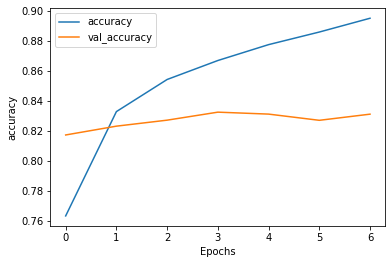

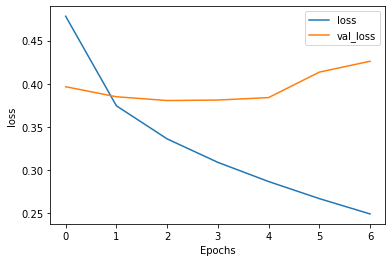

In [103]:
import matplotlib.pyplot as plt

def plot_graphs(history, string):
  plt.plot(history.history[string])
  plt.plot(history.history['val_' + string])
  plt.xlabel("Epochs")
  plt.ylabel(string)
  plt.legend([string, 'val_' + string])
  plt.show()

plot_graphs(history4, 'accuracy')
plot_graphs(history4, 'loss')         #epochs가 많아질때 overfitting될 가능성을 보여줌